<a href="https://colab.research.google.com/github/Emtatos/Football/blob/main/52Crypto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[*********************100%***********************]  1 of 1 completed



📊 Klassfördelning före SMOTE: Counter({'up': 77, 'down': 42, 'stable': 22})

📊 Klassfördelning efter SMOTE: Counter({'up': 77, 'down': 77, 'stable': 77})

🔍 Bästa parametrar: {'final_estimator__logisticregression__C': 1}
🔍 Bästa korskollaccuracy: 45.02164502164502

🏆 Stacking Ensemble Model accuracy: 52.78%

📌 Predicted movement for next period (Stacking): down

--- Rekommendation baserat på Stacking Ensemble ---
⚠️ REKOMMENDATION: Säljläge! (Stacking)


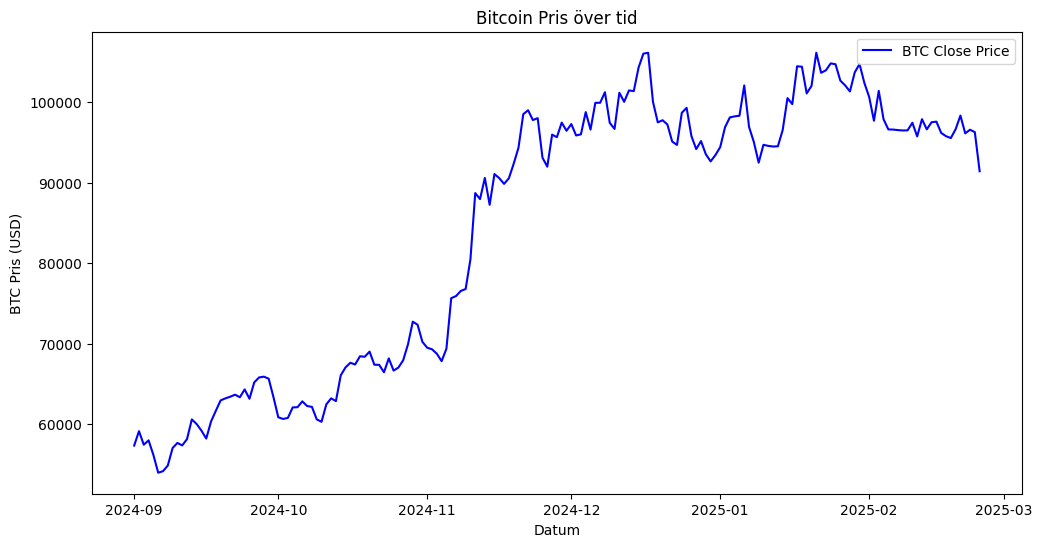

In [6]:
import pandas as pd
import warnings

# Filtrera bort specifika varningar
warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

# ---------------------------
# Steg 1: Installationer & Importer
# ---------------------------
!pip install feedparser yfinance nltk matplotlib scikit-learn xgboost lightgbm ta imbalanced-learn fredapi --upgrade --no-cache-dir

import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from collections import Counter
import ta  # Teknisk analys
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from datetime import datetime

# ---------------------------
# Steg 2: Initiera VADER och ladda ner lexikon
# ---------------------------
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

# ---------------------------
# Datahämtning, bearbetning och feature engineering
# ---------------------------

# Hämta sentiment från RSS-flöden
rss_feeds = [
    "https://www.coindesk.com/arc/outboundfeeds/rss/",
    "https://cointelegraph.com/rss",
    "https://cryptoslate.com/feed"
]

news_entries = []
for url in rss_feeds:
    feed = __import__('feedparser').parse(url)
    for entry in feed.entries:
        if 'published_parsed' in entry and entry.published_parsed:
            entry_date = datetime(*entry.published_parsed[:6]).date()
            text = entry.title
            if 'summary' in entry:
                text += " " + entry.summary
            sentiment_score = sia.polarity_scores(text)['compound']
            news_entries.append({"Date": entry_date, "Sentiment": sentiment_score})

news_df = pd.DataFrame(news_entries)
news_df["Date"] = pd.to_datetime(news_df["Date"])
daily_sentiment = news_df.groupby("Date")["Sentiment"].mean().reset_index()
daily_sentiment.columns = ["Date", "AvgSentiment"]

# Använd de senaste 180 dagarna istället för 360 (snabbare träning)
end_date = pd.to_datetime("today").date()
start_date = end_date - pd.Timedelta(days=180)
# Ange auto_adjust=True för att undvika varningar
btc_data = yf.download("BTC-USD", start=start_date, end=end_date, auto_adjust=True)
btc_data.reset_index(inplace=True)

# Platta ut MultiIndex om det finns (utan utskrift)
if isinstance(btc_data.columns, pd.MultiIndex):
    btc_data.columns = btc_data.columns.get_level_values(0)

btc_data['Date'] = pd.to_datetime(btc_data['Date']).dt.date
daily_sentiment["Date"] = pd.to_datetime(daily_sentiment["Date"]).dt.date

# Merge:a prisdata med sentimentdata
btc_data = pd.merge(btc_data, daily_sentiment, on="Date", how="left")
btc_data["AvgSentiment"] = btc_data["AvgSentiment"].fillna(0)

# Skapa tekniska indikatorer
btc_data["RSI"] = ta.momentum.RSIIndicator(btc_data["Close"], window=14).rsi()
btc_data["SMA_10"] = btc_data["Close"].rolling(window=10).mean()
btc_data["SMA_50"] = btc_data["Close"].rolling(window=50).mean()
btc_data["EMA_10"] = btc_data["Close"].ewm(span=10, adjust=False).mean()
btc_data["Volume_Change"] = btc_data["Volume"].pct_change()

# Extra indikatorer: MACD och Bollinger Bands
macd = ta.trend.MACD(btc_data["Close"])
btc_data["MACD"] = macd.macd()
btc_data["MACD_Signal"] = macd.macd_signal()
btc_data["MACD_Diff"] = macd.macd_diff()

boll = ta.volatility.BollingerBands(btc_data["Close"])
btc_data["Bollinger_High"] = boll.bollinger_hband()
btc_data["Bollinger_Low"] = boll.bollinger_lband()
btc_data["Bollinger_Percent"] = boll.bollinger_pband()

# Skapa målvariabel: Prediktera 3 dagar framåt
btc_data['Next_Close'] = btc_data['Close'].shift(-3)
btc_data.dropna(subset=['Next_Close'], inplace=True)

threshold = 1.0  # Tröskel i procent
btc_data['Movement'] = np.where(
    ((btc_data['Next_Close'] - btc_data['Close']) / btc_data['Close']) * 100 > threshold, 'up',
    np.where(
        ((btc_data['Next_Close'] - btc_data['Close']) / btc_data['Close']) * 100 < -threshold, 'down',
        'stable'
    )
)

# Förbered features – inkludera de nya indikatorerna
feature_cols = ['AvgSentiment', 'RSI', 'SMA_10', 'SMA_50', 'EMA_10',
                'Volume_Change', 'MACD', 'MACD_Signal', 'MACD_Diff', 'Bollinger_Percent']
features = btc_data[feature_cols].copy()
features = features.fillna(0)
labels = btc_data['Movement']

# Dela upp data i tränings- och testset (80/20)
train_size = int(0.8 * len(features))
X_train = features.iloc[:train_size].copy()
X_test = features.iloc[train_size:].copy()
y_train = labels.iloc[:train_size].copy()
y_test = labels.iloc[train_size:].copy()

# Balansera träningsdata med SMOTE
print("\n📊 Klassfördelning före SMOTE:", Counter(y_train))
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print("\n📊 Klassfördelning efter SMOTE:", Counter(y_train_resampled))

# ---------------------------
# Bygg och tunna Stacking Ensemble
# ---------------------------
# Definiera basmodeller med färre estimatorer för snabbare träning
rf_stack = RandomForestClassifier(n_estimators=50, random_state=42)
xgb_stack = XGBClassifier(n_estimators=50, max_depth=5, learning_rate=0.05,
                          subsample=0.7, colsample_bytree=0.7, random_state=42,
                          eval_metric='mlogloss')
lgb_stack = LGBMClassifier(n_estimators=50, max_depth=5, learning_rate=0.05,
                           subsample=0.7, colsample_bytree=0.7, random_state=42, verbose=-1)

# Meta-learner: bygg en pipeline med skalning och LogisticRegression
meta_learner = make_pipeline(StandardScaler(), LogisticRegression(random_state=42, max_iter=5000))
# Använd ett lägre antal cv-foldar (cv=3) för snabbare GridSearch
stack_model = StackingClassifier(
    estimators=[('rf', rf_stack), ('xgb', xgb_stack), ('lgb', lgb_stack)],
    final_estimator=meta_learner,
    cv=3,
    passthrough=True
)

# Använd GridSearchCV för att tunna meta-learnerns C-parameter med färre alternativ
param_grid = {
    "final_estimator__logisticregression__C": [0.1, 1]
}

grid = GridSearchCV(estimator=stack_model, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_resampled, y_train_resampled)
print("\n🔍 Bästa parametrar:", grid.best_params_)
print("🔍 Bästa korskollaccuracy:", grid.best_score_ * 100)

# Utvärdera den bästa modellen på testdata
best_model = grid.best_estimator_
y_pred_stack = best_model.predict(X_test)
stack_accuracy = accuracy_score(y_test, y_pred_stack) * 100
print(f"\n🏆 Stacking Ensemble Model accuracy: {stack_accuracy:.2f}%")

# Prediktera framtida rörelse med den bästa modellen
last_features = features.iloc[[-1]].copy()
next_day_pred_stack = best_model.predict(last_features)[0]
print(f"\n📌 Predicted movement for next period (Stacking): {next_day_pred_stack}")

# Rekommendation baserat på Stacking Ensemble
print("\n--- Rekommendation baserat på Stacking Ensemble ---")
if next_day_pred_stack == 'up':
    print("🚀 REKOMMENDATION: Köpläge! (Stacking)")
elif next_day_pred_stack == 'down':
    print("⚠️ REKOMMENDATION: Säljläge! (Stacking)")
else:
    print("🔍 REKOMMENDATION: Avvakta. (Stacking)")

# ---------------------------
# Visualisering av BTC-prisutvecklingen
# ---------------------------
plt.figure(figsize=(12,6))
plt.plot(btc_data['Date'], btc_data['Close'], label='BTC Close Price', color='blue')
plt.xlabel('Datum')
plt.ylabel('BTC Pris (USD)')
plt.title('Bitcoin Pris över tid')
plt.legend()
plt.show()